# Import Data, Clean Data, Visualize Data

In [1]:
# Initial Import of Dependencies
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import psycopg2 as pg

In [2]:
engine = pg.connect("dbname='d3r8dfuncb78iv' user='jrufhfiejfajri' host='ec2-52-200-155-213.compute-1.amazonaws.com' port='5432' password='9a7254d2151b5e3c280fe275dbba039acdc9190fbc167f64c564c449ca77af88'")
fire_df = pd.read_sql('select * from wildfire_data', con=engine)

In [3]:
# Check Data Types
fire_df.dtypes

fire_year          int64
district          object
unit              object
fire_number       object
fire_name         object
legal             object
latitude          object
longitude         object
fuel_model        object
county            object
report_date       object
general_cause     object
odf_acres        float64
total_acres      float64
dtype: object

In [4]:
# Alt Function to convert DMS to Decimal

#def dms_to_dd(d, m, s):
    #dd = d + float(m)/60 + float(s)/3600
    #return dd

# Converting Lat/Long DMS to Decimal
pattern = r'(?P<d>[\d\.]+).*?(?P<m>[\d\.]+).*?(?P<s>[\d\.]+)'

#Lat
dms = fire_df['latitude'].str.extract(pattern).astype(float)
fire_df['Latitude'] = dms['d'] + dms['m'].div(60) + dms['s'].div(3600)

#Long  
dms = fire_df['longitude'].str.extract(pattern).astype(float)
fire_df['Longitude'] = dms['d'] + dms['m'].div(60) + dms['s'].div(3600)

# Convert all Longtiude to Negative
fire_df['Longitude'] *= -1

fire_df.head(5)

,fire_year,district,unit,fire_number,fire_name,legal,latitude,longitude,fuel_model,county,report_date,general_cause,odf_acres,total_acres,Latitude,Longitude
0,2021,73 - Douglas,Central,470,Strickland Canyon,None,None,None,None,DOUGLAS,2021-05-17,Under Invest,0.01,NaN,NaN,NaN
1,2021,77 - South Cascade,East Lane,1,Holiday Farm 2,None,None,None,None,None,2021-07-01,Under Invest,1.00,NaN,NaN,NaN
2,2021,95 - Central Oregon,Sisters,61,Russell 0931,None,43° 40' 2,-121° 29' 40,None,None,2021-09-06,Under Invest,0.10,NaN,43.667222,-121.494444
3,2016,55 - West Oregon,Toledo,10,OAR Fire,T7S R11W S23 SWNW,44° 57' 13,-124° 0' 26,J,LINCOLN,2016-08-23,Smoking,0.10,0.10,44.953611,-124.007222
4,2016,72 - Coos,Bridge,178,Ashur Flat,T31S R9W S30 SENW,42° 50' 46,-123° 49' 9,H,DOUGLAS,2016-06-13,Equipment Use,0.01,0.01,42.846111,-123.819167


In [5]:
# Drop DMS Lat/Long/odf_acres
fire_df = fire_df.drop(['latitude', 'longitude', "odf_acres"], axis=1)
# Confirm Dropped Columns
fire_df.head(5)

,fire_year,district,unit,fire_number,fire_name,legal,fuel_model,county,report_date,general_cause,total_acres,Latitude,Longitude
0,2021,73 - Douglas,Central,470,Strickland Canyon,None,None,DOUGLAS,2021-05-17,Under Invest,NaN,NaN,NaN
1,2021,77 - South Cascade,East Lane,1,Holiday Farm 2,None,None,None,2021-07-01,Under Invest,NaN,NaN,NaN
2,2021,95 - Central Oregon,Sisters,61,Russell 0931,None,None,None,2021-09-06,Under Invest,NaN,43.667222,-121.494444
3,2016,55 - West Oregon,Toledo,10,OAR Fire,T7S R11W S23 SWNW,J,LINCOLN,2016-08-23,Smoking,0.10,44.953611,-124.007222
4,2016,72 - Coos,Bridge,178,Ashur Flat,T31S R9W S30 SENW,H,DOUGLAS,2016-06-13,Equipment Use,0.01,42.846111,-123.819167


In [6]:
# Drop the null columns where all values are null
fire_df = fire_df.dropna(axis='columns', how='all')

# Drop the null rows
fire_df = fire_df.dropna()

# Are fires increasing over time?

<AxesSubplot:xlabel='fire_year'>

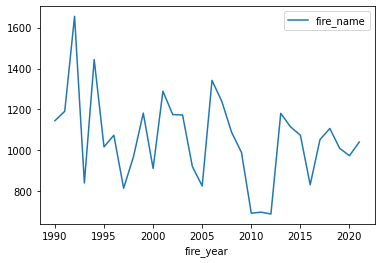

In [7]:
# Group fires by fire_year and see how many fires occur each year and visualize this on a line plot
fire_count = fire_df[['fire_year', 'fire_name']]
fire_count = fire_count.groupby('fire_year').count()
fire_count.plot.line()

### The number of fires seems to be decreasing over time, but what about the number of acres burned is this decreasing over time as well?

<AxesSubplot:xlabel='fire_year'>

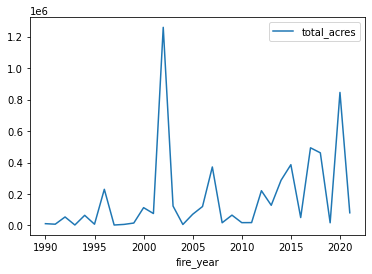

In [8]:
# Group fires by year and sume the acres burned each year then visualize in a line plot
acres_sum = fire_df[['fire_year', 'total_acres']]
acres_sum = acres_sum.groupby('fire_year').sum('total_acres')
acres_sum.plot.line()

### The number of acres burned seems to be increasing over time with many more acres burned between 2010 and 2020 than previous with the exception of 2002.

# How does one county compare to another in number of fires? Could this impact fire severity?

<AxesSubplot:xlabel='county'>

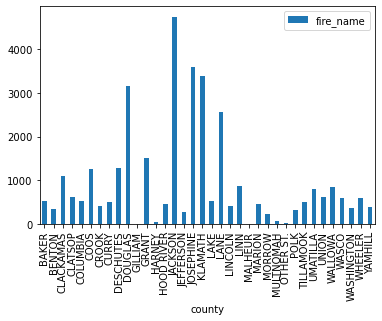

In [9]:
# Group by county and visualize number of fires burned in bar graph
county_count = fire_df[['county', 'fire_name']]
county_count = county_count.groupby('county').count()
county_count.plot.bar()

<AxesSubplot:xlabel='county'>

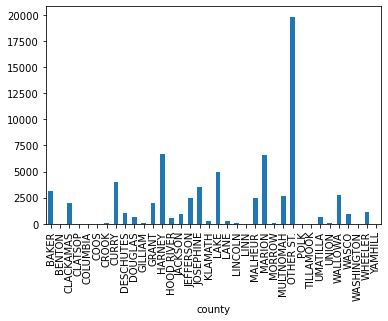

In [10]:
# Group by county and visualize number of average number of acres burned in bar graph
county_count_mean = (fire_df.groupby(['county', 'total_acres'], as_index=False).mean().groupby('county')['total_acres'].mean())
county_count_mean.plot.bar()


#### There are only a few counties where avg acres burned is really high? Should we consider looking at only these counties?

<AxesSubplot:>

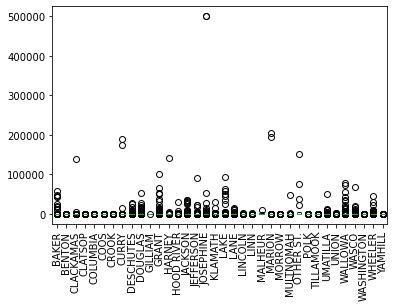

In [20]:
# See boxplot of acres burned by county
fire_df.assign(index=fire_df.groupby('county').cumcount()).pivot('index','county','total_acres').plot(kind='box', rot=90)


### Question
#### Should we consider correlating county with fuel type?

# Could fuel type effect the number of acres burned?

## Visualize the fuel models against acres burned

<AxesSubplot:>

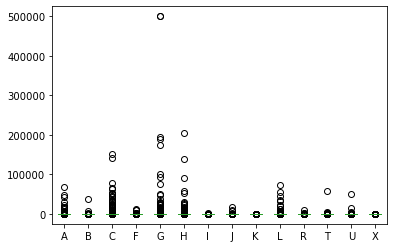

In [13]:
# Boxplot of fuel model vs acres burned
fire_df.assign(index=fire_df.groupby('fuel_model').cumcount()).pivot('index','fuel_model','total_acres').plot(kind='box')


In [77]:
# Drop columns that are inconsequential and see stats for fuel model vs total acres
fire_fuel = fire_df.drop(['fire_year', "Latitude", 'Longitude'], axis=1)
fire_fuel.groupby('fuel_model').describe()

total_acres                                                        \
                 count         mean           std   min    25%   50%     75%   
fuel_model                                                                     
A               5784.0    69.107469   1419.371967  0.00  0.010  0.10  0.5000   
B                248.0   194.374960   2448.617723  0.01  0.095  0.25  1.0000   
C               7104.0   188.716601   3411.752358  0.00  0.020  0.10  0.3500   
F               2294.0    21.632280    419.076203  0.00  0.010  0.10  0.5000   
G               1438.0  1628.388032  21076.162526  0.00  0.010  0.10  0.2500   
H               5486.0   157.266850   3806.738172  0.00  0.010  0.10  0.2500   
I                701.0     8.087589     53.839096  0.00  0.010  0.10  0.6300   
J               2058.0    22.972881    448.776017  0.00  0.030  0.15  1.5000   
K                921.0     1.818947     13.668347  0.00  0.010  0.10  0.5000   
L               3669.0    97.946650   1988.583573  0.00  0.010  0.10  0.6000   
R               1024.0    16.696553    353.240208  0.00  0.010  0.10  0.7275   
T                512.0   163.645840   2524.484654  0.00  0.100  0.22  2.4250   
U                413.0   186.104843   2613.835428  0.01  0.100  0.10  0.4000   
X               2103.0     0.542183      7.449650  0.00  0.010  0.01  0.1000   

                       
                  max  
fuel_model             
A            68135.00  
B            38050.00  
C           152270.00  
F            13119.00  
G           499945.00  
H           204469.00  
I             1080.00  
J            16436.00  
K              348.00  
L            73500.00  
R            11141.06  
T            56766.20  
U            50951.00  
X              200.00

#### The fire that burned 500,000 acres could be skewing the data, drop to see if this changes the visual and see if we can see a pattern in the rest of the data

<AxesSubplot:>

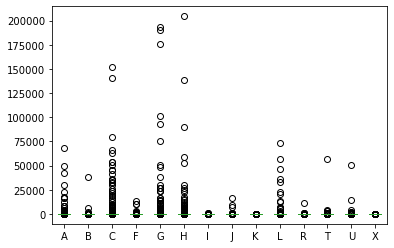

In [66]:
# Drop fire burning more than 300,000 acres (this removed 2 fires)
fire_df_removed = fire_df[fire_df['total_acres'] < 300000]
fire_df_removed.assign(index=fire_df_removed.groupby('fuel_model').cumcount()).pivot('index','fuel_model','total_acres').plot(kind='box')


## What if we just look at fires that burned more than 100,000 acres and compare those fuel types? Will we see any differences?

<AxesSubplot:>

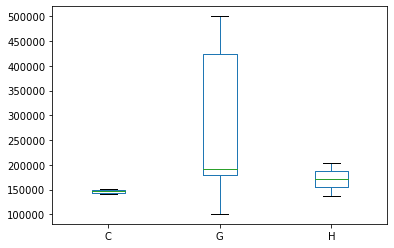

In [23]:
# Drop fires less than 100,000 acres and make boxplot by by fuel type
fire_df_reallybigfires = fire_df[fire_df['total_acres'] > 100000]
fire_df_reallybigfires.assign(index=fire_df_reallybigfires.groupby('fuel_model').cumcount()).pivot('index','fuel_model','total_acres').plot(kind='box')



In [25]:
# Drop inconsequential columns and see stats for total acres per fuel model. Did this change much after 
# removing fires above 300,000 acres?
fire_fuel_reallybigfires_stats = fire_df_reallybigfires.drop(['fire_year','Latitude', 'Longitude'], axis=1)
fire_fuel_reallybigfires_stats.groupby('fuel_model').describe()

total_acres                                                \
                 count      mean            std       min        25%   
fuel_model                                                             
C                  2.0  146315.0    8421.641764  140360.0  143337.50   
G                  6.0  276722.0  176155.602891  101028.0  179091.00   
H                  2.0  171261.5   46962.496873  138054.0  154657.75   

                                           
                 50%        75%       max  
fuel_model                                 
C           146315.0  149292.50  152270.0  
G           192078.0  423350.25  499945.0  
H           171261.5  187865.25  204469.0

### Questions
1) There are over 7,000 fires for fire model C and over 5,000 for fire model A & H. Could these fuel types have a greater impact on fire severity?
2) Fuel type G still shows the highest mean acres burned (over 900 acres). Maybe this fuel type is related to greater fire severity?
3) When looking at fires that burned over 100,000 acres, fuel types C, G, and H are they only fuel types that show in the data.

#### Run Random Forest Classifier to see how these fuel models relate to outcomes
#### Give each fire a severity level for predictions


# Begin Prepping data for ML models

In [82]:
# Import LE to convert Fuel Model and General Cause to Numeric Values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Converting Fuel Model to Numeric
label_encoder = LabelEncoder()
fire_df["fueltype_num"] = label_encoder.fit_transform(fire_df["fuel_model"])

In [83]:
# Converting General Cause to Numeric 
label_encoder = LabelEncoder()
fire_df["generalCause_num"] = label_encoder.fit_transform(fire_df["general_cause"])

In [84]:
#Drop All Row where Total Acres is less then 1
#fire_df.drop(fire_df[fire_df.total_acres < 1].index, inplace=True)
#fire_df.head(20)

In [85]:
# Set and Classify Fire Sizes
fire_df.loc[fire_df['total_acres'] <= 10, 'fire_severity'] = 1
fire_df.loc[(fire_df['total_acres'] > 10) & (fire_df['total_acres'] <= 100), 'fire_severity'] = 2
fire_df.loc[(fire_df['total_acres'] > 100) & (fire_df['total_acres'] <= 1000), 'fire_severity'] = 3
fire_df.loc[(fire_df['total_acres'] > 1000) & (fire_df['total_acres'] <= 10000), 'fire_severity'] = 4
fire_df.loc[fire_df['total_acres'] > 10000, 'fire_severity'] = 5                                                    

In [86]:
print(fire_df['fire_severity'].value_counts())

1.0    31989
2.0     1131
3.0      404
4.0      135
5.0       96
Name: fire_severity, dtype: int64
